In [30]:
import time
import torch
from utils import image_utils
from utils.image_utils import gen_index_file
from unet.dataset import SegThorImagesDataset
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 
from unet.unet_model import UNet
from unet import simplified_unet_model
from unet.loss import GeneralizedDiceLoss
from torch import optim
from torch import nn
import os 
import pandas as pd 
from utils import model_utils

from importlib import reload 

In [23]:
DATA_DIR = '/home/jupyter/ecs271_data/data/train'
EXPERIMENT_DIR = '/home/jupyter/ecs271_data/experiments'
TRAIN_CSV = "data/train_patient_idx_sorted.csv"
VALID_CSV = "data/valid_patient_idx_sorted.csv"
INPUT_DATA_INDEX = 'data/train_patient_idx.csv'
TEST_CSV = "data/test_patient_idx.csv"

In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. ")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead.")

GPU is available. 


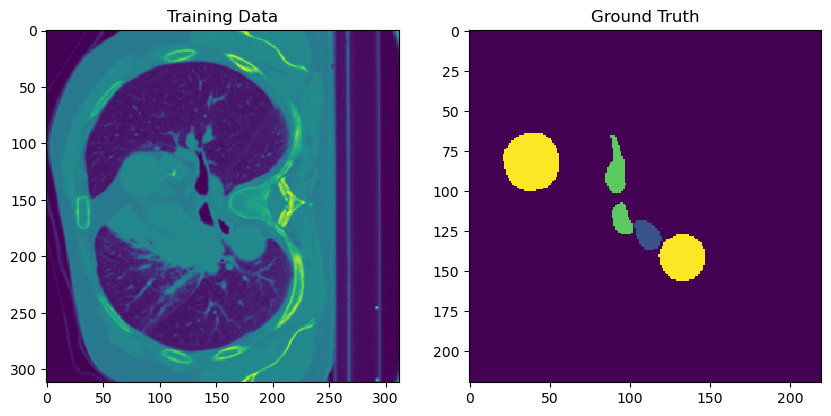

In [27]:

test_dataset = SegThorImagesDataset(
    patient_idx_file=TEST_CSV,
    root_dir=DATA_DIR,
    img_crop_size=312, 
    mask_output_size=220,
    cache_size=1,
    # transform=transforms
    )

test_dl = DataLoader(test_dataset, batch_size=3)

X, Y = test_dataset[400]

image_utils.plot_XY(X[0, :, :].squeeze(0), Y.squeeze(0))

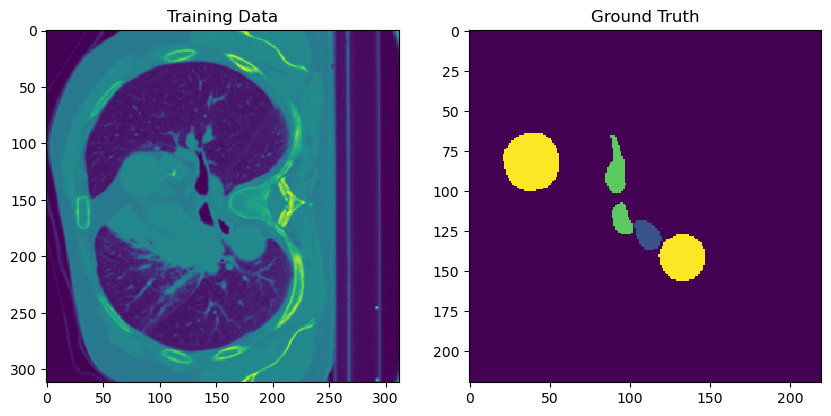

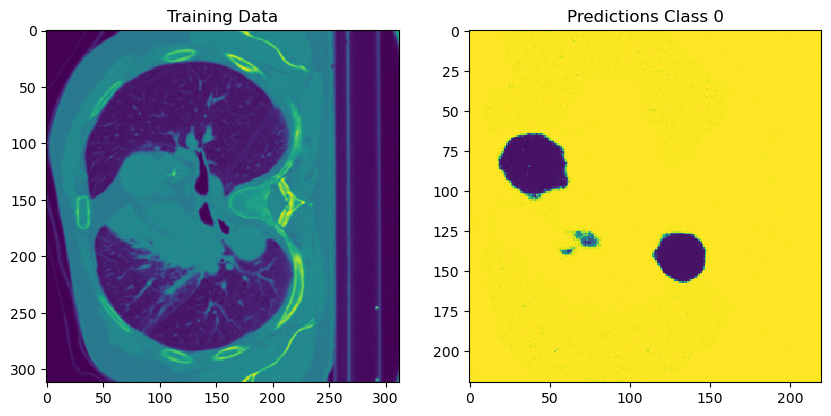

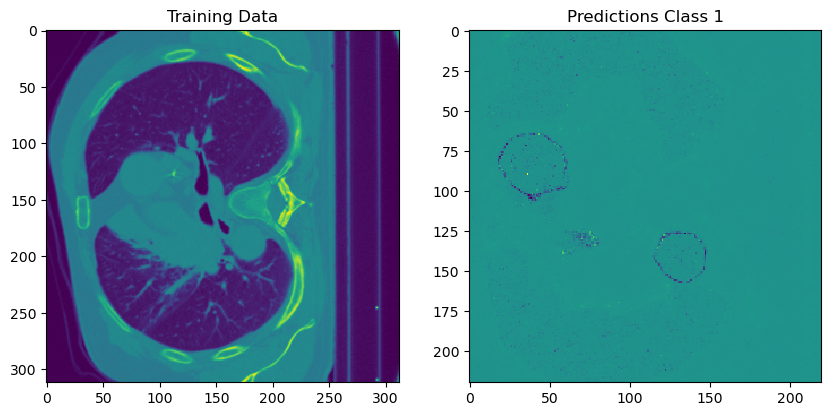

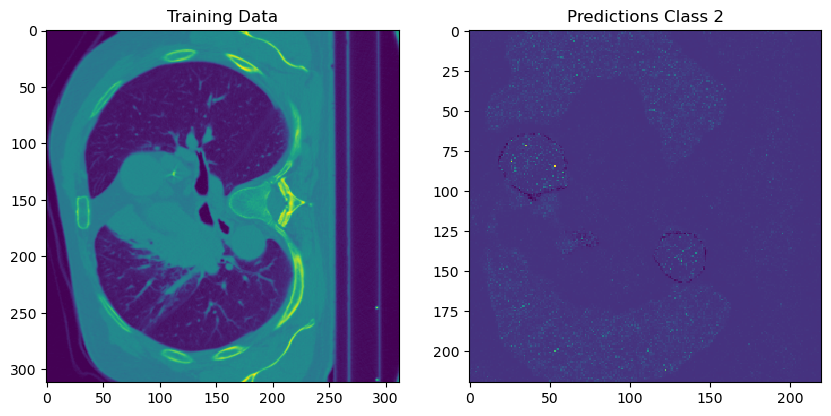

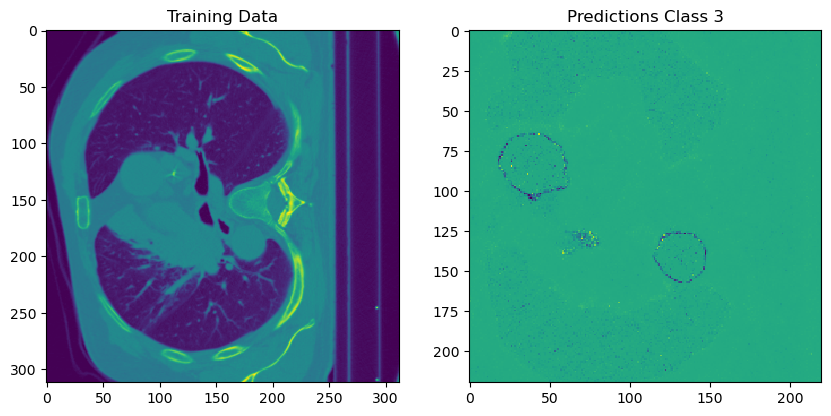

In [32]:
experiment_name = 'simplified_unet_08_limited_train'
model = simplified_unet_model.SimplifiedUNet(n_channels=1, n_classes=5, dropout=0.2)
model = model_utils.get_model_from_checkpoint(experiment_dir=EXPERIMENT_DIR,
                                              experiment_name = experiment_name, 
                                              model=model,
                                              epoch=18)

X, Y = test_dataset[400]
image_utils.plot_XY_for_preds(model, X, Y)

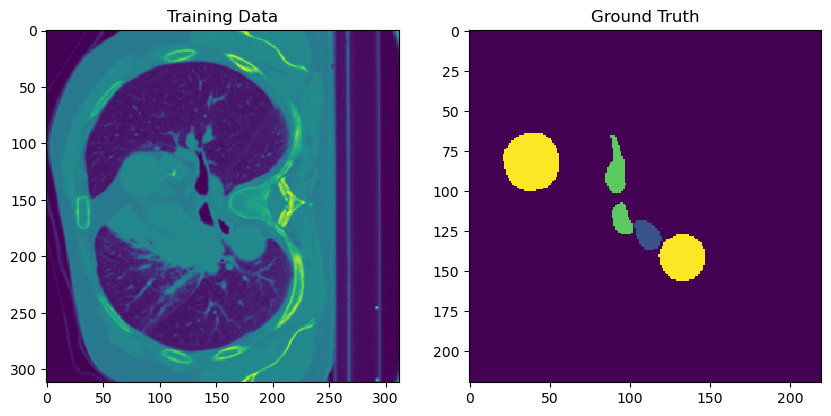

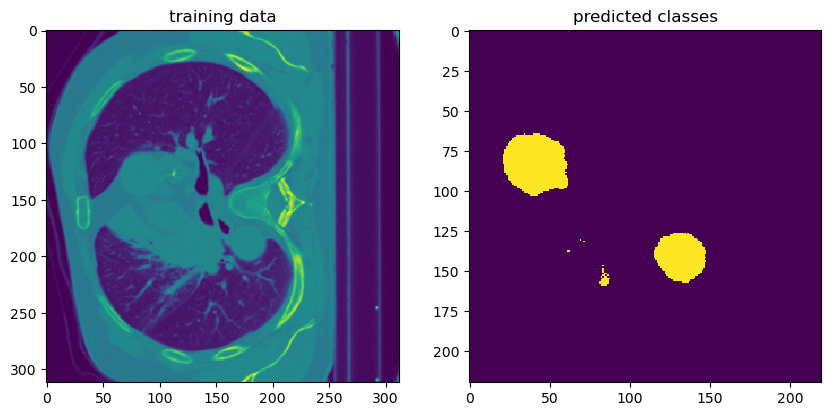

In [33]:
image_utils.plot_XY_pred_class(model, X, Y)

In [14]:
# Contrastive Discrepancy Review 

# per channel
classes = [0, 1, 2, 3, 4]

# binarize the probability by class 

# Find the indices of the maximum values along the channels dimension
max_indices = torch.argmax(probas_13, dim=1, keepdim=True)
predicted_channels = torch.zeros_like(probas_13)
predicted_channels = predicted_channels.scatter_(1, max_indices, 1)

# need to cast Y to channel dim
Y_c = torch.zeros_like(predicted_channels)
for c in classes:
    Y_c[:, c, :, :] = (Y.unsqueeze(0)==c).int()

In [15]:
Y_c

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          

In [18]:
# mask is the region of disagreement
mask = torch.logical_xor(predicted_channels, Y_c)
# clip: obtain predictions from binarized in the masked area
clipped_predicted = torch.logical_and(mask, predicted_channels).float()
# MSE of predictions between clipped and region of disagreement
clipped_y = torch.logical_and(mask, Y_c).float()

# size of disagreement region as weights
weights = mask.sum(dim=(-1, -2))
weights

tensor([[785, 185, 636,   0, 164]])

In [27]:
weights_view = weights.unsqueeze(2).unsqueeze(3)
weights_view.shape

torch.Size([1, 5, 1, 1])

In [28]:
SE = ((clipped_predicted - clipped_y)**2)


SE.shape

torch.Size([1, 5, 220, 220])

In [35]:
class RectificationLoss(nn.Module):
    """
    Given input from two models and 1 label, implement the Contrastive Discrepancy Review loss
    """
    def __init__(self, classes = [0, 1, 2, 3, 4]):
        super().__init__()
        self.classes = classes
        
    def _probas_to_class_channels(self, probas_1):
        """
        Convert the probabilities of dim [batch x channel x height x width] to labels 0/1. 
        A 1 in the channel means that pixel is labeled that channel (e.g. [batch x 3 x h x w] = 1 --> that pixel is a label 3)
        """
        # Find the indices of the maximum values along the channels dimension
        max_indices = torch.argmax(probas_1, dim=1, keepdim=True)
        predicted_channels = torch.zeros_like(probas_1)
        predicted_channels = predicted_channels.scatter_(1, max_indices, 1)
        return predicted_channels
    
    def _targets_to_class_channels(self, targets):
        """
        Convert the targets [batch x h x w] to [batch x channel x h x w] where a 1 in the channel
        corresponds to a label
        """
        assert len(targets.shape) == 3, f"targets shape: {targets.shape} not 3"
        target_channels = torch.zeros_like(targets.unsqueeze(1))
        
        for c in self.classes:
            target_channels[:, c, :, :] = (targets.unsqueeze(1) == c).int()
        return target_channels
    
    def _disagreement_mask(self, predicted_channels_1, predicted_channels_2):
        return torch.logical_xor(predicted_channels_1, predicted_channels_2)
    
    
    
    def forward(self, probas_1, probas_2, targets):
        assert len(probas_1.shape) == 4, f"{probas_1.shape} is not correct dimension"
        assert len(probas_2.shape) == 4, f"{probas_2.shape} is not correct dimension"
        assert probas_1.shape == probas_2.shape, f"{probas_1.shape} != {probas_2.shape}"
        # per channel
        predicted_channels_1 = self._probas_to_class_channels(probas_1)
        predicted_channels_2 = self._probas_to_class_channels(probas_2)
        target_channels = self._targets_to_class_channels(targets)
        # get region of disagreement between the two predictions for each channel
        mask = self._disagreement_mask(predicted_channels_1, predicted_channels_2)
        
        


# mask is the region of disagreement
mask = torch.logical_xor(predicted_channels, Y_c)
# clip: obtain predictions from binarized in the masked area
clipped_predicted = torch.logical_and(mask, predicted_channels).float()
# MSE of predictions between clipped and region of disagreement
clipped_y = torch.logical_and(mask, Y_c).float()

# size of disagreement region as weights
weights = mask.sum(dim=(-1, -2))
weights


class weighted_MSELoss(nn.Module):

    def forward(self,inputs, targets, weights):
        assert len(weights.shape) == 4, f"weights.shape: {weights.shape} not expected dimensions"
        assert weights.shape[0] == inputs.shape[0], f"weights.shape: {weights.shape} not expected dimensions"
        assert weights.shape[1] == inputs.shape[1], f"weights.shape: {weights.shape} not expected dimensions"
        assert weights.shape[2] == 1, f"weights.shape: {weights.shape} not expected dimensions"
        assert weights.shape[3] == 1, f"weights.shape: {weights.shape} not expected dimensions"
        
        weighted_SE = (((inputs - targets)**2 ) * weights)
        # mean across H x W and Channel
        return weighted_SE.mean(dim=(-1, -2, -3))

# mean across channels
mse = weighted_MSELoss()

mse(clipped_predicted, clipped_y, weights_view).shape

torch.Size([1])

In [ ]:
# average MSE for the clipped region between two models